In [5]:
years = list(range(1990,2023))

dfs = []
for year in years:
    with open("mvp/{}.html".format(year)) as f:
        page = f.read()
    
    soup = BeautifulSoup(page, 'html.parser')
    soup.find('tr', class_="over_header").decompose()
    mvp_table = soup.find_all(id="mvp")[0]
    mvp_df = pd.read_html(str(mvp_table))[0]
    mvp_df["Year"] = year
    dfs.append(mvp_df)

mvps = pd.concat(dfs)

mvps.head()

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,...,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Year
0,1,Magic Johnson,30,LAL,27.0,636.0,920,0.691,79,37.2,...,6.6,11.5,1.7,0.4,0.480,0.384,0.890,16.5,0.270,1990
1,2,Charles Barkley,26,PHI,38.0,614.0,920,0.667,79,39.1,...,11.5,3.9,1.9,0.6,0.600,0.217,0.749,17.3,0.269,1990
2,3,Michael Jordan,26,CHI,21.0,564.0,920,0.613,82,39.0,...,6.9,6.3,2.8,0.7,0.526,0.376,0.848,19.0,0.285,1990
3,4,Karl Malone,26,UTA,2.0,214.0,920,0.233,82,38.1,...,11.1,2.8,1.5,0.6,0.562,0.372,0.762,15.9,0.245,1990
4,5,Patrick Ewing,27,NYK,1.0,162.0,920,0.176,82,38.6,...,10.9,2.2,1.0,4.0,0.551,0.250,0.775,13.5,0.205,1990


In [7]:
#!pip install requests
#import requests
def assign_mvp(row):
    if row['Rank'] == 1:
        return 1
    else:
        return 0

# Assuming 'mvps' is your main DataFrame
mvps['MVP'] = mvps.apply(lambda row: assign_mvp(row), axis=1)

print(mvps)

   Rank           Player  Age   Tm  First  Pts Won  Pts Max  Share   G    MP  \
0     1    Magic Johnson   30  LAL   27.0    636.0      920  0.691  79  37.2   
1     2  Charles Barkley   26  PHI   38.0    614.0      920  0.667  79  39.1   
2     3   Michael Jordan   26  CHI   21.0    564.0      920  0.613  82  39.0   
3     4      Karl Malone   26  UTA    2.0    214.0      920  0.233  82  38.1   
4     5    Patrick Ewing   27  NYK    1.0    162.0      920  0.176  82  38.6   
..  ...              ...  ...  ...    ...      ...      ...    ...  ..   ...   
7     8    Stephen Curry   33  GSW    0.0      4.0     1000  0.004  64  34.5   
8     9       Chris Paul   36  PHO    0.0      2.0     1000  0.002  65  32.9   
9   10T    DeMar DeRozan   32  CHI    0.0      1.0     1000  0.001  76  36.1   
10  10T     Kevin Durant   33  BRK    0.0      1.0     1000  0.001  55  37.2   
11  10T     LeBron James   37  LAL    0.0      1.0     1000  0.001  56  37.2   

    ...   AST  STL  BLK    FG%    3P%  

   Rank           Player  Age   Tm  First  Pts Won  Pts Max  Share   G    MP  \
0     1    Magic Johnson   30  LAL   27.0    636.0      920  0.691  79  37.2   
1     2  Charles Barkley   26  PHI   38.0    614.0      920  0.667  79  39.1   
2     3   Michael Jordan   26  CHI   21.0    564.0      920  0.613  82  39.0   
3     4      Karl Malone   26  UTA    2.0    214.0      920  0.233  82  38.1   
4     5    Patrick Ewing   27  NYK    1.0    162.0      920  0.176  82  38.6   
..  ...              ...  ...  ...    ...      ...      ...    ...  ..   ...   
7     8    Stephen Curry   33  GSW    0.0      4.0     1000  0.004  64  34.5   
8     9       Chris Paul   36  PHO    0.0      2.0     1000  0.002  65  32.9   
9   10T    DeMar DeRozan   32  CHI    0.0      1.0     1000  0.001  76  36.1   
10  10T     Kevin Durant   33  BRK    0.0      1.0     1000  0.001  55  37.2   
11  10T     LeBron James   37  LAL    0.0      1.0     1000  0.001  56  37.2   

    ...   AST  STL  BLK    FG%    3P%  

In [131]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import commonplayerinfo
import pandas as pd

# Assuming you have your DataFrame as `mvps`
# Add new columns for nationality and position
mvps['Nationality'] = ''
mvps['Position'] = ''

# Get all players
players_dict = players.get_players()

# Function to get player info
def get_player_info(full_name, year):
    # Find player id
    player_list = [player for player in players_dict if player['full_name'].lower() == full_name.lower()]
    print(full_name)
    for player in player_list:
        player_id = player['id']
        # Query the commonplayerinfo endpoint
        player_info = commonplayerinfo.CommonPlayerInfo(player_id=player_id).get_normalized_dict()
        player_info_data = player_info['CommonPlayerInfo'][0]
        
        # Check if the year from mvps DataFrame falls within the player's active years
        if year >= int(player_info_data['FROM_YEAR']) and year <= int(player_info_data['TO_YEAR']):
            print(player_info_data['COUNTRY'], player_info_data['POSITION'])
            return player_info_data['COUNTRY'], player_info_data['POSITION']
    
    # If no player matches the active years, return None
    return None, None

# Iterate over the DataFrame rows
for index, row in mvps.iterrows():
    # Get player information from the nba_api
    nationality, position = get_player_info(row['Player'], row['Year'])
    # Assign the information to the respective columns
    print(index)
    if nationality and position:
        mvps.at[index, 'Nationality'] = nationality
        mvps.at[index, 'Position'] = position

# Ensure the DataFrame is updated with the new information
print(mvps.head())


Michael Jordan
USA Guard
0
Magic Johnson
USA Forward-Guard
1
David Robinson
USA Center
2
Charles Barkley
USA Forward
3
Karl Malone
USA Forward
4
Clyde Drexler
USA Guard
5
Kevin Johnson
USA Guard
6
Dominique Wilkins
USA Forward
7
Larry Bird
USA Forward
8
Terry Porter
USA Guard
9
Patrick Ewing
Jamaica Center
10
John Stockton
USA Guard
11
Isiah Thomas
USA Guard
12
Robert Parish
USA Center
13
Joe Dumars
USA Guard
14
Bernard King
USA Forward
15
Kenny Smith
USA Guard
16
Hakeem Olajuwon
Nigeria Center
17
Tim Hardaway
USA Guard
18
Kevin McHale
USA Forward
19
Michael Jordan
USA Guard
0
Clyde Drexler
USA Guard
1
David Robinson
USA Center
2
Karl Malone
USA Forward
3
Patrick Ewing
Jamaica Center
4
Chris Mullin
USA Forward
5
Mark Price
USA Guard
6
Tim Hardaway
USA Guard
7
Scottie Pippen
USA Forward-Guard
8
Dennis Rodman
USA Forward
9
Brad Daugherty
USA Center
10
Charles Barkley
USA Forward
11
John Stockton
USA Guard
12
Larry Bird
13
Kevin Johnson
USA Guard
14
Danny Manning
USA Forward-Center
15
Det

KeyboardInterrupt: 

In [4]:


from nba_api.stats.endpoints import playercareerstats


player_info = playercareerstats.PlayerCareerStats(player_id='77142').get_normalized_dict()  # LeBron James' player ID as an example
player_info_data = player_info['SeasonTotalsRegularSeason']

print(player_info_data)
player_info_data['SEASON_ID']

[{'PLAYER_ID': 77142, 'SEASON_ID': '1979-80', 'LEAGUE_ID': '00', 'TEAM_ID': 1610612747, 'TEAM_ABBREVIATION': 'LAL', 'PLAYER_AGE': 20.0, 'GP': 77, 'GS': 72, 'MIN': 2795.0, 'FGM': 503, 'FGA': 949, 'FG_PCT': 0.53, 'FG3M': 7, 'FG3A': 31, 'FG3_PCT': 0.226, 'FTM': 374, 'FTA': 462, 'FT_PCT': 0.81, 'OREB': 166, 'DREB': 430, 'REB': 596, 'AST': 563, 'STL': 187, 'BLK': 41, 'TOV': 305, 'PF': 218, 'PTS': 1387}, {'PLAYER_ID': 77142, 'SEASON_ID': '1980-81', 'LEAGUE_ID': '00', 'TEAM_ID': 1610612747, 'TEAM_ABBREVIATION': 'LAL', 'PLAYER_AGE': 21.0, 'GP': 37, 'GS': 35, 'MIN': 1371.0, 'FGM': 312, 'FGA': 587, 'FG_PCT': 0.532, 'FG3M': 3, 'FG3A': 17, 'FG3_PCT': 0.176, 'FTM': 171, 'FTA': 225, 'FT_PCT': 0.76, 'OREB': 101, 'DREB': 219, 'REB': 320, 'AST': 317, 'STL': 127, 'BLK': 27, 'TOV': 143, 'PF': 100, 'PTS': 798}, {'PLAYER_ID': 77142, 'SEASON_ID': '1981-82', 'LEAGUE_ID': '00', 'TEAM_ID': 1610612747, 'TEAM_ABBREVIATION': 'LAL', 'PLAYER_AGE': 22.0, 'GP': 78, 'GS': 77, 'MIN': 2991.0, 'FGM': 556, 'FGA': 1036, 'F

TypeError: list indices must be integers or slices, not str

In [9]:
from nba_api.stats.endpoints import commonplayerinfo

player_info = commonplayerinfo.CommonPlayerInfo(player_id=77142).get_normalized_dict()
player_info_data = player_info['CommonPlayerInfo'][0]

print(player_info_data['FROM_YEAR'])
'''
if 2020 >= int(player_info_data['FROM_YEAR']):
    print('Active')
'''

1979


"\nif 2020 >= int(player_info_data['FROM_YEAR']):\n    print('Active')\n"

In [140]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import commonplayerinfo
import pandas as pd

# Assuming you have your DataFrame as `mvps`
# It's a good idea to reset the index to ensure it's in proper order.
mvps.reset_index(drop=True, inplace=True)

# Add new columns for nationality and position
mvps['Nationality'] = ''
mvps['Position'] = ''

# Function to replace special characters
def replace_special_characters(name):
    replacements = {'ć': 'c', 'ó': 'o', 'č': 'c'}
    for original, replacement in replacements.items():
        name = name.replace(original, replacement)
    return name

# Get all players
players_dict = players.get_players()

# Function to get player info
def get_player_info(full_name, year):
    # Replace special characters in the player's name
    full_name = replace_special_characters(full_name)

    # Find player id
    player_list = [player for player in players_dict if player['full_name'].lower() == full_name.lower()]
    
    for player in player_list:
        player_id = player['id']
        # Query the commonplayerinfo endpoint
        player_info = commonplayerinfo.CommonPlayerInfo(player_id=player_id).get_normalized_dict()
        player_info_data = player_info['CommonPlayerInfo'][0]


        # Check if the adjusted year from mvps DataFrame falls within the player's active years
        if year >= int(player_info_data['FROM_YEAR']) and year <= int(player_info_data['TO_YEAR']):
            return player_info_data['COUNTRY'], player_info_data['POSITION']
    
    # If no player matches the active years, return None
    return None, None

# Iterate over the DataFrame rows
for index, row in mvps.iterrows():
    # Adjust the year here before sending it to the get_player_info function
    adjusted_year = row['Year'] - 1

    # Get player information from the nba_api
    nationality, position = get_player_info(row['Player'], adjusted_year)
    
    # Assign the information to the respective columns using the correct index
    if nationality and position:
        mvps.at[index, 'Nationality'] = nationality
        mvps.at[index, 'Position'] = position
    else:
        # Log if there was an issue retrieving the data
        print(f"No data found for player: {row['Player']} in year {row['Year']}")

# Ensure the DataFrame is updated with the new information
print(mvps.head())


No data found for player: Steve Smith in year 1997
No data found for player: Steve Smith in year 1999
  Rank           Player  Age   Tm  First  Pts Won  Pts Max  Share   G    MP  \
0    1   Michael Jordan   27  CHI   77.0    891.0      960  0.928  82  37.0   
1    2    Magic Johnson   31  LAL   10.0    497.0      960  0.518  79  37.1   
2    3   David Robinson   25  SAS    6.0    476.0      960  0.496  82  37.7   
3    4  Charles Barkley   27  PHI    2.0    222.0      960  0.231  67  37.3   
4    5      Karl Malone   27  UTA    0.0    142.0      960  0.148  82  40.3   

   ...  STL  BLK    FG%    3P%    FT%    WS  WS/48  Year  Nationality  \
0  ...  2.7  1.0  0.539  0.312  0.851  20.3  0.321  1991          USA   
1  ...  1.3  0.2  0.477  0.320  0.906  15.4  0.251  1991          USA   
2  ...  1.5  3.9  0.552  0.143  0.762  17.0  0.264  1991          USA   
3  ...  1.6  0.5  0.570  0.284  0.722  13.4  0.258  1991          USA   
4  ...  1.1  1.0  0.527  0.286  0.770  15.5  0.225  1991  

In [143]:
[player for player in players_dict if player['full_name'].lower() == '']

    Rank             Player  Age   Tm  First  Pts Won  Pts Max  Share   G  \
0      1     Michael Jordan   27  CHI   77.0    891.0      960  0.928  82   
1      2      Magic Johnson   31  LAL   10.0    497.0      960  0.518  79   
2      3     David Robinson   25  SAS    6.0    476.0      960  0.496  82   
3      4    Charles Barkley   27  PHI    2.0    222.0      960  0.231  67   
4      5        Karl Malone   27  UTA    0.0    142.0      960  0.148  82   
..   ...                ...  ...  ...    ...      ...      ...    ...  ..   
469   11  Russell Westbrook   32  WAS    0.0      5.0     1010  0.005  65   
470   12        Ben Simmons   24  PHI    0.0      3.0     1010  0.003  58   
471  13T       James Harden   31  TOT    0.0      1.0     1010  0.001  44   
472  13T       LeBron James   36  LAL    0.0      1.0     1010  0.001  45   
473  13T      Kawhi Leonard   29  LAC    0.0      1.0     1010  0.001  52   

       MP  ...  STL  BLK    FG%    3P%    FT%    WS  WS/48  Year  Nationali

(1) Datenerhebung mittels Web Scraping UND Web API (muss Teil des Python Codes sein, einfache File-Downloads zählen nicht)

In [33]:
years = list(range(1991,2022))
'''
url_start = "https://www.basketball-reference.com/awards/awards_{}.html"

for year in years:
    url = url_start.format(year)
    
    data = requests.get(url)
    
    with open("mvp/{}.html".format(year), "w+") as f:
        f.write(data.text)
'''

#via API
# Nikola Jokić
career = playercareerstats.PlayerCareerStats(player_id='203999') 

# pandas data frames (optional: pip install pandas)
career.get_data_frames()[0]

# json
career.get_json()

# dictionary
career.get_dict()

{'resource': 'playercareerstats',
 'parameters': {'PerMode': 'Totals', 'PlayerID': 203999, 'LeagueID': None},
 'resultSets': [{'name': 'SeasonTotalsRegularSeason',
   'headers': ['PLAYER_ID',
    'SEASON_ID',
    'LEAGUE_ID',
    'TEAM_ID',
    'TEAM_ABBREVIATION',
    'PLAYER_AGE',
    'GP',
    'GS',
    'MIN',
    'FGM',
    'FGA',
    'FG_PCT',
    'FG3M',
    'FG3A',
    'FG3_PCT',
    'FTM',
    'FTA',
    'FT_PCT',
    'OREB',
    'DREB',
    'REB',
    'AST',
    'STL',
    'BLK',
    'TOV',
    'PF',
    'PTS'],
   'rowSet': [[203999,
     '2015-16',
     '00',
     1610612743,
     'DEN',
     21.0,
     80,
     55,
     1733.0,
     307,
     600,
     0.512,
     28,
     84,
     0.333,
     154,
     190,
     0.811,
     181,
     379,
     560,
     189,
     79,
     50,
     104,
     208,
     796],
    [203999,
     '2016-17',
     '00',
     1610612743,
     'DEN',
     22.0,
     73,
     59,
     2038.0,
     494,
     854,
     0.578,
     45,
     139,
     0.

In [97]:
from bs4 import BeautifulSoup

In [98]:
with open("mvp/1991.html") as f:
    page = f.read()

In [99]:
soup = BeautifulSoup(page, 'html.parser')

In [100]:
soup.find('tr', class_="over_header").decompose()

In [101]:

mvp_table = soup.find_all(id="mvp")
print(mvp_table)


[<table class="sortable stats_table" data-cols-to-freeze=",2" id="mvp">
<caption>Most Valuable Player (Michael Jordan Trophy) Table</caption>
<colgroup><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/></colgroup>
<thead>

<tr>
<th aria-label="rank" class="poptip center" data-stat="rank" scope="col">Rank</th>
<th aria-label="Player" class="poptip sort_default_asc left" data-stat="player" scope="col">Player</th>
<th aria-label="Age" class="poptip sort_default_asc center" data-stat="age" data-tip="Player's age on February 1 of the season" scope="col">Age</th>
<th aria-label="Tm" class="poptip sort_default_asc left" data-stat="team_id" data-tip="Team" scope="col">Tm</th>
<th aria-label="First" class="poptip right" data-over-header="Voting" data-stat="votes_first" data-tip="First Place Votes" scope="col">First</th>
<th aria-label="Pts Won" class="poptip right" data-over-header="Voting" data-stat="points_won" scope="col">

In [102]:
mvp_1991 = pd.read_html(str(mvp_table))[0]
mvp_1991.head(1)

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,1,Michael Jordan,27,CHI,77.0,891.0,960,0.928,82,37.0,31.5,6.0,5.5,2.7,1.0,0.539,0.312,0.851,20.3,0.321


In [12]:
mvp_1991["Year"] = 1991
mvp_1991.head()

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,...,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Year
0,1,Michael Jordan,27,CHI,77.0,891.0,960,0.928,82,37.0,...,6.0,5.5,2.7,1.0,0.539,0.312,0.851,20.3,0.321,1991
1,2,Magic Johnson,31,LAL,10.0,497.0,960,0.518,79,37.1,...,7.0,12.5,1.3,0.2,0.477,0.320,0.906,15.4,0.251,1991
2,3,David Robinson,25,SAS,6.0,476.0,960,0.496,82,37.7,...,13.0,2.5,1.5,3.9,0.552,0.143,0.762,17.0,0.264,1991
3,4,Charles Barkley,27,PHI,2.0,222.0,960,0.231,67,37.3,...,10.1,4.2,1.6,0.5,0.570,0.284,0.722,13.4,0.258,1991
4,5,Karl Malone,27,UTA,0.0,142.0,960,0.148,82,40.3,...,11.8,3.3,1.1,1.0,0.527,0.286,0.770,15.5,0.225,1991


In [92]:
#mvp_table['MVP Share'] = mvp_table["Pts Won"] / mvp_table['Pts Max']

print(mvp_table.head())
#erster immer MVP

TypeError: 'NoneType' object is not callable

In [147]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import playergamelog
import numpy as np

# Liste aller Spieler abrufen
players_list = players.get_players()

# Beispiel: Spielerdaten für LeBron James
lebron = [player for player in players_list if player['full_name'] == 'LeBron James'][0]
lebron_id = lebron['id']

# LeBron James' Spieler-Log für eine Saison abrufen
log = playergamelog.PlayerGameLog(player_id=lebron_id, season='2022')
df = log.get_data_frames()[0]  # DataFrame mit den Daten


print(df.head())
print(commonplayerinfo.CommonPlayerInfo(player_id=2544).get_normalized_dict())

  SEASON_ID  Player_ID     Game_ID     GAME_DATE      MATCHUP WL  MIN  FGM  \
0     22022       2544  0022201228  APR 09, 2023  LAL vs. UTA  W   33   13   
1     22022       2544  0022201212  APR 07, 2023  LAL vs. PHX  W   29    6   
2     22022       2544  0022201196  APR 05, 2023    LAL @ LAC  L   35   13   
3     22022       2544  0022201186  APR 04, 2023    LAL @ UTA  W   38   14   
4     22022       2544  0022201171  APR 02, 2023    LAL @ HOU  W   29    8   

   FGA  FG_PCT  ...  DREB  REB  AST  STL  BLK  TOV  PF  PTS  PLUS_MINUS  \
0   25   0.520  ...     5    6    6    1    1    2   0   36          20   
1   19   0.316  ...     6    6    6    0    0    5   1   16          11   
2   20   0.650  ...     8    8    7    1    1    6   0   33         -10   
3   27   0.519  ...     5    5    6    1    1    5   2   37          -7   
4   18   0.444  ...     8   10   11    0    1    1   1   18          23   

   VIDEO_AVAILABLE  
0                1  
1                1  
2                

Speichern der Daten in einer Database wie MySQL oder PostgreSQL sowie SQL Abfragen aus dieser (SQLite zählt nicht!!!)

In [16]:
#import pymysql


db = pymysql.connect(host="secondtest.cfis62ku07hb.eu-central-1.rds.amazonaws.com", user="admin", password="12345678")

In [17]:
cursor = db.cursor()
cursor.execute("select version()")

1

In [18]:
data = cursor.fetchall()
data 
#MySQL Version

(('8.0.35',),)

In [19]:
#sql = '''create database if not exists myfirstawsdb'''
#cursor.execute(sql)
#cursor.connection.commit()


In [20]:
sql = '''use myfirstawsdb'''
cursor.execute(sql)


0

In [21]:
# CREATE TABLE Anweisung für die Tabelle 'player_game_log'
create_table_query = """
CREATE TABLE IF NOT EXISTS player_game_log (
    Player_ID INT,
    Season VARCHAR(7),
    Game_ID VARCHAR(15),
    Game_Date DATE,
    MATCHUP VARCHAR(15),
    WL CHAR(1),
    MIN INT,
    FGM INT,
    FGA INT,
    FG_PCT FLOAT,
    FG3M INT,
    FG3A INT,
    FG3_PCT FLOAT,
    FTM INT,
    FTA INT,
    FT_PCT FLOAT,
    OREB INT,
    DREB INT,
    REB INT,
    AST INT,
    STL INT,
    BLK INT,
    TOV INT,
    PF INT,
    PTS INT,
    PLUS_MINUS INT,
    VIDEO_AVAILABLE TINYINT,
    AST_TO_TOV_RATIO FLOAT
    -- Fügen Sie weitere Spalten basierend auf Ihren Datenanforderungen hinzu
);
"""

# Führen Sie die CREATE TABLE Anweisung aus
cursor.execute(create_table_query)

# Commit (Bestätigen) Sie die Änderungen, falls erforderlich
db.commit()
#'''


In [22]:
sql = '''show tables'''
cursor.execute(sql)
cursor.fetchall()

(('player_game_log',),)

In [23]:
# INSERT INTO Anweisung vorbereiten
def insert_player_game_log(player_game_log_df, player_id):

    # SQL insert statement
    insert_stmt = (
        "INSERT INTO player_game_log (Player_ID, Season, Game_ID, Game_Date, MATCHUP, WL, MIN, FGM, FGA, FG_PCT, FG3M, FG3A, FG3_PCT, FTM, FTA, FT_PCT, OREB, DREB, REB, AST, STL, BLK, TOV, PF, PTS, PLUS_MINUS, VIDEO_AVAILABLE, AST_TO_TOV_RATIO) "
        "VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
        )
        
    # Insert data into the table
    for index, row in player_game_log_df.iterrows():
        data = (
            row['Player_ID'],
            row['SEASON_ID'],  # Make sure this column name matches the one in your DataFrame
            row['Game_ID'],
            row['GAME_DATE'],
            row['MATCHUP'],
            row['WL'],
            row['MIN'],
            row['FGM'],
            row['FGA'],
            row['FG_PCT'],
            row['FG3M'],
            row['FG3A'],
            row['FG3_PCT'],
            row['FTM'],
            row['FTA'],
            row['FT_PCT'],
            row['OREB'],
            row['DREB'],
            row['REB'],
            row['AST'],
            row['STL'],
            row['BLK'],
            row['TOV'],
            row['PF'],
            row['PTS'],
            row['PLUS_MINUS'],
            row['VIDEO_AVAILABLE'],
            row['AST_TO_TOV_RATIO']
    
        )
        cursor.execute(insert_stmt, data)
        
        # Commit the transaction
    db.commit()
    print(cursor.rowcount, "records inserted successfully into player_game_log table")
        
# Main logic
players_list = players.get_players()
lebron = [player for player in players_list if player['full_name'] == 'LeBron James'][0]
lebron_id = lebron['id']

# Retrieve player game log for LeBron James for a specific season
game_log = playergamelog.PlayerGameLog(player_id=lebron_id, season='2022')
player_game_log_df = game_log.get_data_frames()[0]


# Add assist to turnover ratio --> Datenaufbereitung (z.B. Entfernen NAs und Duplikate, Erstellen neuer Variablen, Anreicherung der Daten, ...)
# Handle division by zero by setting the ratio to NaN where TOV is 0
player_game_log_df['AST_TO_TOV_RATIO'] = df.apply(lambda x: x['AST'] / x['TOV'] if x['TOV'] > 0 else 0, axis=1)

# Insert the data into SQL
insert_player_game_log(player_game_log_df, lebron_id)


1 records inserted successfully into player_game_log table


In [24]:
sql = '''select * from player_game_log'''
cursor.execute(sql)


127

In [26]:
cursor.close()
db.close()

In [66]:
dfs = []
for year in years:
    with open("mvp/{}.html".format(year)) as f:
        page = f.read()
    
    soup = BeautifulSoup(page, 'html.parser')
    soup.find('tr', class_="over_header").decompose()
    mvp_table = soup.find_all(id="mvp")[0]
    mvp_df = pd.read_html(str(mvp_table))[0]
    mvp_df["Year"] = year
    dfs.append(mvp_df)

In [47]:
mvps = pd.concat(dfs)



print(mvps.head())

<class 'pandas.core.frame.DataFrame'>
  Rank           Player  Age   Tm  First  Pts Won  Pts Max  Share   G    MP  \
0    1   Michael Jordan   27  CHI   77.0    891.0      960  0.928  82  37.0   
1    2    Magic Johnson   31  LAL   10.0    497.0      960  0.518  79  37.1   
2    3   David Robinson   25  SAS    6.0    476.0      960  0.496  82  37.7   
3    4  Charles Barkley   27  PHI    2.0    222.0      960  0.231  67  37.3   
4    5      Karl Malone   27  UTA    0.0    142.0      960  0.148  82  40.3   

   ...   TRB   AST  STL  BLK    FG%    3P%    FT%    WS  WS/48  Year  
0  ...   6.0   5.5  2.7  1.0  0.539  0.312  0.851  20.3  0.321  1991  
1  ...   7.0  12.5  1.3  0.2  0.477  0.320  0.906  15.4  0.251  1991  
2  ...  13.0   2.5  1.5  3.9  0.552  0.143  0.762  17.0  0.264  1991  
3  ...  10.1   4.2  1.6  0.5  0.570  0.284  0.722  13.4  0.258  1991  
4  ...  11.8   3.3  1.1  1.0  0.527  0.286  0.770  15.5  0.225  1991  

[5 rows x 21 columns]


In [52]:
print(mvps.dtypes)

Rank        object
Player      object
Age          int64
Tm          object
First      float64
Pts Won    float64
Pts Max      int64
Share      float64
G            int64
MP         float64
PTS        float64
TRB        float64
AST        float64
STL        float64
BLK        float64
FG%        float64
3P%        float64
FT%        float64
WS         float64
WS/48      float64
Year         int64
dtype: object


In [53]:
print(mvps.isnull().sum())

Rank        0
Player      0
Age         0
Tm          0
First       0
Pts Won     0
Pts Max     0
Share       0
G           0
MP          0
PTS         0
TRB         0
AST         0
STL         0
BLK         0
FG%         0
3P%        11
FT%         0
WS          0
WS/48       0
Year        0
dtype: int64


In [56]:
print(mvps.describe())

              Age       First      Pts Won      Pts Max       Share  \
count  474.000000  474.000000   474.000000   474.000000  474.000000   
mean    27.729958    7.544304   196.105485  1153.312236    0.170030   
std      3.859979   22.870329   316.020240   111.589513    0.272154   
min     19.000000    0.000000     1.000000   960.000000    0.001000   
25%     25.000000    0.000000     4.000000  1010.000000    0.003000   
50%     28.000000    0.000000    26.000000  1210.000000    0.024500   
75%     30.000000    1.000000   260.250000  1240.000000    0.230250   
max     38.000000  131.000000  1310.000000  1310.000000    1.000000   

                G          MP         PTS         TRB         AST         STL  \
count  474.000000  474.000000  474.000000  474.000000  474.000000  474.000000   
mean    72.962025   36.405063   22.298945    7.501899    5.212447    1.401477   
std     10.570344    3.044097    5.132908    3.282469    2.722344    0.539495   
min     17.000000   25.600000    4.7

In [58]:
print(mvps['Tm'].value_counts())

Tm
SAS    41
LAL    28
UTA    27
PHO    26
HOU    22
MIA    22
DAL    20
GSW    19
CHI    18
CLE    18
ORL    17
DET    17
BOS    16
OKC    15
PHI    14
POR    14
LAC    13
MIN    13
SEA    13
SAC    11
TOR    10
DEN    10
NYK    10
ATL     9
IND     9
MIL     8
TOT     7
WAS     7
NOH     6
MEM     3
CHH     3
NOP     3
NJN     3
CHA     1
WSB     1
Name: count, dtype: int64


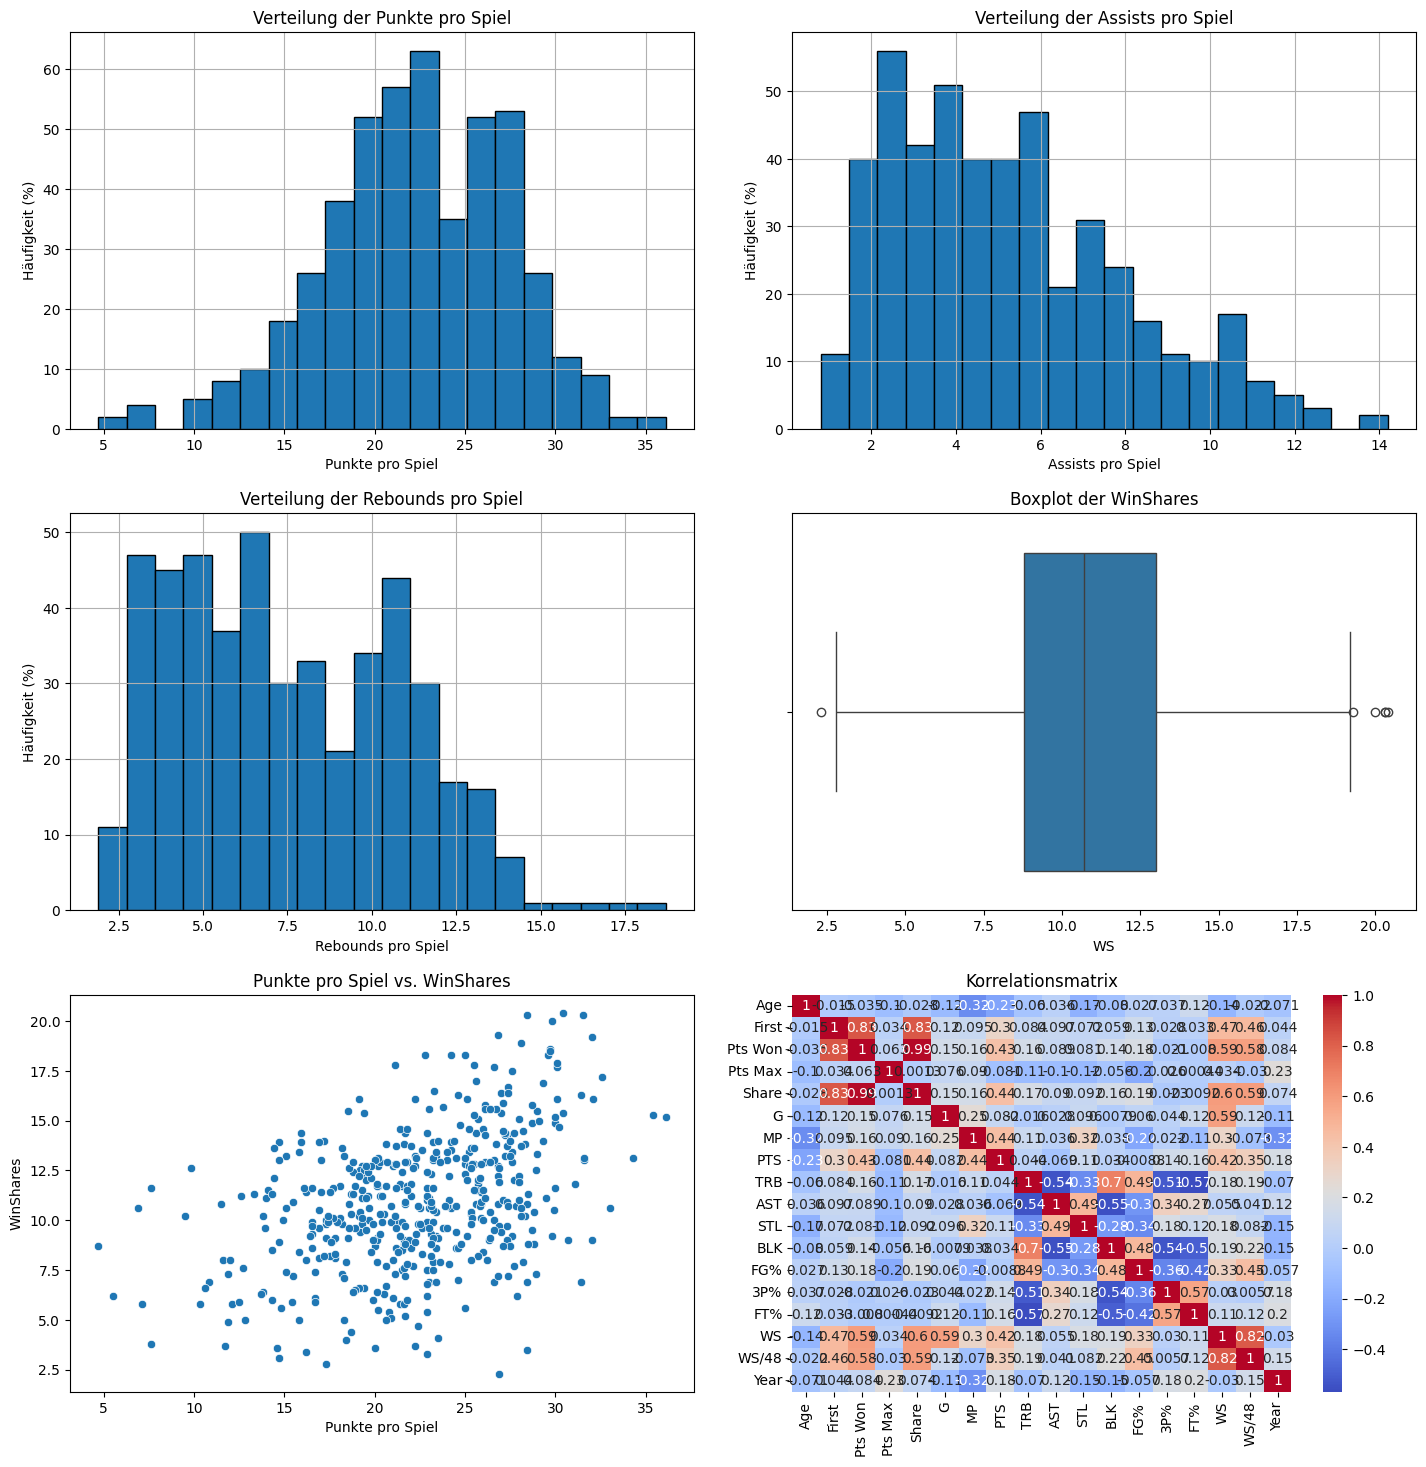

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

# Erstellen eines 3x2 Grids für die Plots
fig, axs = plt.subplots(3, 2, figsize=(15, 15))  # Größe kann nach Bedarf angepasst werden

# Anpassung des Layouts für eine bessere Anzeige
plt.tight_layout(pad=4.0)

# Histogramm der Punkte pro Spiel
mvps['PTS'].hist(bins=20, edgecolor='black', ax=axs[0, 0])
axs[0, 0].set_title('Verteilung der Punkte pro Spiel')
axs[0, 0].set_xlabel('Punkte pro Spiel')
axs[0, 0].set_ylabel('Häufigkeit (%)')

# Histogramm der Assists pro Spiel
mvps['AST'].hist(bins=20, edgecolor='black', ax=axs[0, 1])
axs[0, 1].set_title('Verteilung der Assists pro Spiel')
axs[0, 1].set_xlabel('Assists pro Spiel')
axs[0, 1].set_ylabel('Häufigkeit (%)')

# Histogramm der Rebounds pro Spiel
mvps['TRB'].hist(bins=20, edgecolor='black', ax=axs[1, 0])
axs[1, 0].set_title('Verteilung der Rebounds pro Spiel')
axs[1, 0].set_xlabel('Rebounds pro Spiel')
axs[1, 0].set_ylabel('Häufigkeit (%)')

# Boxplot zur Darstellung der Verteilung der WinShares
sns.boxplot(x='WS', data=mvps, ax=axs[1, 1])
axs[1, 1].set_title('Boxplot der WinShares')

# Scatterplot zur Visualisierung der Beziehung zwischen Punkten pro Spiel und WinShares
sns.scatterplot(x='PTS', y='WS', data=mvps, ax=axs[2, 0])
axs[2, 0].set_title('Punkte pro Spiel vs. WinShares')
axs[2, 0].set_xlabel('Punkte pro Spiel')
axs[2, 0].set_ylabel('WinShares')

# Korrelationsmatrix der numerischen Merkmale
# Auswahl nur der numerischen Spalten für die Korrelationsmatrix
numerical_cols = [col for col in mvps.columns if mvps[col].dtype != 'object']
numerical_mvps = mvps[numerical_cols]
correlation_matrix = numerical_mvps.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axs[2, 1])
axs[2, 1].set_title('Korrelationsmatrix')

plt.show()


In [79]:
print(numerical_mvps.corr())


              Age     First   Pts Won   Pts Max     Share         G        MP  \
Age      1.000000 -0.014641 -0.035480 -0.100551 -0.027898 -0.120310 -0.323661   
First   -0.014641  1.000000  0.831203  0.033547  0.826405  0.116574  0.094846   
Pts Won -0.035480  0.831203  1.000000  0.063047  0.993340  0.153218  0.162127   
Pts Max -0.100551  0.033547  0.063047  1.000000  0.001299  0.076031  0.090190   
Share   -0.027898  0.826405  0.993340  0.001299  1.000000  0.152164  0.157046   
G       -0.120310  0.116574  0.153218  0.076031  0.152164  1.000000  0.247545   
MP      -0.323661  0.094846  0.162127  0.090190  0.157046  0.247545  1.000000   
PTS     -0.230426  0.296712  0.425749 -0.080950  0.442163  0.082471  0.443640   
TRB     -0.060263  0.084188  0.155008 -0.112793  0.169398 -0.015999  0.111839   
AST      0.035831  0.096827  0.088838 -0.102683  0.089896  0.027883  0.036232   
STL     -0.167017  0.071815  0.081283 -0.124258  0.092480  0.096215  0.324122   
BLK     -0.079770  0.059141 

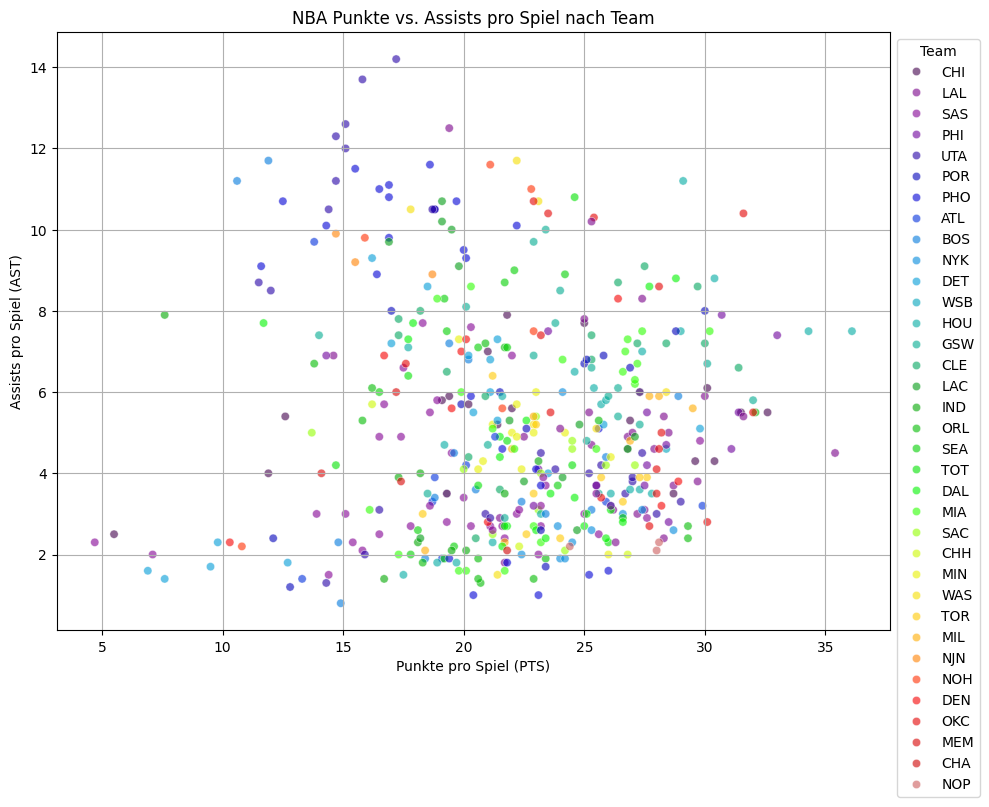

In [83]:

# Setzen einer größeren Figurgröße für bessere Lesbarkeit
plt.figure(figsize=(10, 8))

# Scatterplot mit einer klareren Farbpalette
sns.scatterplot(data=mvps, x='PTS', y='AST', hue='Tm', 
                palette='nipy_spectral', alpha=0.6)

# Verbesserung der Achsenbeschriftungen
plt.xlabel('Punkte pro Spiel (PTS)')
plt.ylabel('Assists pro Spiel (AST)')

# Hinzufügen eines Gitternetzes
plt.grid(True)

# Setzen eines aussagekräftigen Titels
plt.title('NBA Punkte vs. Assists pro Spiel nach Team')

# Anpassen der Legende
plt.legend(title='Team', bbox_to_anchor=(1, 1), loc='upper left')

# Anzeige des verbesserten Plots
plt.tight_layout()  # Verhindert Abschneiden der Beschriftungen
plt.show()


In [85]:
#!pip install statsmodels

  Using cached statsmodels-0.14.1-cp312-cp312-win_amd64.whl.metadata (9.8 kB)
     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ------------ ------------------------- 20.5/60.6 kB 330.3 kB/s eta 0:00:01
     -------------------------------- ----- 51.2/60.6 kB 525.1 kB/s eta 0:00:01
     -------------------------------------- 60.6/60.6 kB 535.5 kB/s eta 0:00:00
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
    --------------------------------------- 0.2/9.8 MB 4.6 MB/s eta 0:00:03
   -- ------------------------------------- 0.6/9.8 MB 7.5 MB/s eta 0:00:02
   ---- ----------------------------------- 1.1/9.8 MB 9.1 MB/s eta 0:00:01
   ------ --------------------------------- 1.7/9.8 MB 9.8 MB/s eta 0:00:01
   --------- ------------------------------ 2.3/9.8 MB 10.3 MB/s eta 0:00:01
   ----------- ---------------------------- 2.8/9.8 MB 10.4 MB/s eta 0:00:01
   ------------- -------------------------- 3.3/9.8 MB 10.6 MB/s eta 0:00:01
   ---

In [86]:
import statsmodels.api as sm

# Bereite die Daten vor: füge eine Konstante hinzu, um das Achsenabschnitts-Term zu berücksichtigen
X = sm.add_constant(mvps['WS'])  # Unabhängige Variable
Y = mvps['First']  # Abhängige Variable

# Führe das lineare Regressionsmodell aus
model = sm.OLS(Y, X).fit()

# Zeige eine Zusammenfassung des Modells
model_summary = model.summary()
print(model_summary)


                            OLS Regression Results                            
Dep. Variable:                  First   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     130.9
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           6.31e-27
Time:                        11:30:16   Log-Likelihood:                -2097.6
No. Observations:                 474   AIC:                             4199.
Df Residuals:                     472   BIC:                             4208.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -26.9052      3.151     -8.538      0.0

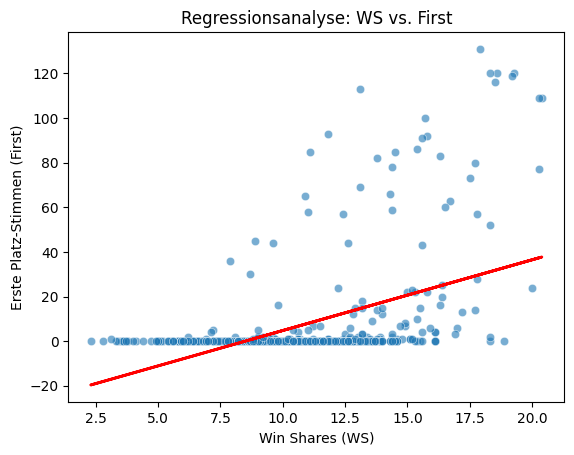

In [87]:
# Zeichnen der Beobachtungspunkte
sns.scatterplot(x='WS', y='First', data=mvps, alpha=0.6)

# Berechnen der Werte auf der Regressionslinie
# Hierfür verwenden wir den Regressionskoeffizienten und das Achsenabschnitt
predicted_values = model.params['const'] + model.params['WS'] * mvps['WS']

# Zeichnen der Regressionslinie
plt.plot(mvps['WS'], predicted_values, color='red', linewidth=2)

# Achsen und Titel beschriften
plt.xlabel('Win Shares (WS)')
plt.ylabel('Erste Platz-Stimmen (First)')
plt.title('Regressionsanalyse: WS vs. First')

# Zeige die erstellte Grafik
plt.show()


In [149]:
print(mvps)

    Rank             Player  Age   Tm  First  Pts Won  Pts Max  Share   G  \
0      1     Michael Jordan   27  CHI   77.0    891.0      960  0.928  82   
1      2      Magic Johnson   31  LAL   10.0    497.0      960  0.518  79   
2      3     David Robinson   25  SAS    6.0    476.0      960  0.496  82   
3      4    Charles Barkley   27  PHI    2.0    222.0      960  0.231  67   
4      5        Karl Malone   27  UTA    0.0    142.0      960  0.148  82   
..   ...                ...  ...  ...    ...      ...      ...    ...  ..   
469   11  Russell Westbrook   32  WAS    0.0      5.0     1010  0.005  65   
470   12        Ben Simmons   24  PHI    0.0      3.0     1010  0.003  58   
471  13T       James Harden   31  TOT    0.0      1.0     1010  0.001  44   
472  13T       LeBron James   36  LAL    0.0      1.0     1010  0.001  45   
473  13T      Kawhi Leonard   29  LAC    0.0      1.0     1010  0.001  52   

       MP  ...  STL  BLK    FG%    3P%    FT%    WS  WS/48  Year  Nationali